In [52]:
# Import necessary libraries
import numpy as np
import pandas as pd
import os
from obspy import read
from obspy.signal.filter import bandpass
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define data directories
TRAIN_DATA_DIR = './data/training/data/S12_GradeA/'
TRAIN_CATALOG_FILE = './data/training/catalogs/apollo12_catalog_GradeA_final.csv'
TEST_DATA_DIR = './data/training/data/S12_GradeA/'

# Load the training catalog
catalog = pd.read_csv(TRAIN_CATALOG_FILE)


In [32]:
# Function to load seismic data from a file
def load_seismic_data(filename, data_dir=TRAIN_DATA_DIR):
    mseed_file = os.path.join(data_dir, filename + '.mseed')
    st = read(mseed_file)
    tr = st[0]
    data = tr.data
    sampling_rate = tr.stats.sampling_rate
    starttime = tr.stats.starttime.datetime
    return data, sampling_rate, starttime

# Prepare lists to hold data and labels
X = []
y = []

# Parameters for data segmentation
WINDOW_SIZE = 512  # Number of samples per segment (adjust as needed)
STEP_SIZE = 128     # Step size for sliding window (adjust as needed)
EVENT_WINDOW_LABEL = 1
NO_EVENT_WINDOW_LABEL = 0

# Bandpass filter parameters (adjust as needed)
FREQ_MIN = 0.5  # Hz
FREQ_MAX = 2.0  # Hz

# Load data and labels
for idx, row in catalog.iterrows():
    filename = row['filename']
    arrival_time_rel = row['time_rel(sec)']
    # Load seismic data
    data, sampling_rate, starttime = load_seismic_data(filename)
    # Apply bandpass filter
    data = bandpass(data, FREQ_MIN, FREQ_MAX, sampling_rate, corners=4, zerophase=True)
    # Normalize data
    data = (data - np.mean(data)) / np.std(data)
    # Calculate event sample index
    event_sample_idx = int(float(arrival_time_rel) * sampling_rate)
    # Slide a window over the data
    num_segments = (len(data) - WINDOW_SIZE) // STEP_SIZE + 1
    for i in range(num_segments):
        start_idx = i * STEP_SIZE
        end_idx = start_idx + WINDOW_SIZE
        window_data = data[start_idx:end_idx]
        # Check if the event is within this window
        if event_sample_idx >= start_idx and event_sample_idx < end_idx:
            label = EVENT_WINDOW_LABEL
        else:
            label = NO_EVENT_WINDOW_LABEL
        # Append to lists
        X.append(window_data)
        y.append(label)

# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)
print(f'Total segments: {len(X)}')


Total segments: 337032


In [33]:
for idx, row in catalog.iterrows():
    filename = row['filename']
    arrival_time_rel = row['time_rel(sec)']
    # Load seismic data
    data, sampling_rate, starttime = load_seismic_data(filename)
    # Apply bandpass filter
    data = bandpass(data, FREQ_MIN, FREQ_MAX, sampling_rate, corners=4, zerophase=True)
    # Normalize data
    data = (data - np.mean(data)) / np.std(data)
    # Calculate event sample index
    event_sample_idx = int(arrival_time_rel * sampling_rate)
    print(event_sample_idx)
    print(len(data))
    break

486937
572415


In [34]:
# Count the number of samples in each class
unique, counts = np.unique(y, return_counts=True)
print(f'Class distribution before balancing: {dict(zip(unique, counts))}')

# Oversample the minority class
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X.reshape(-1, WINDOW_SIZE), y)

print(f'Class distribution after balancing: {dict(zip(*np.unique(y_resampled, return_counts=True)))}')

# Reshape X for CNN input (samples, timesteps, channels)
X_resampled = X_resampled[..., np.newaxis]


Class distribution before balancing: {0: 336728, 1: 304}
Class distribution after balancing: {0: 336728, 1: 336728}


In [35]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

print(f'Training data shape: {X_train.shape}')
print(f'Validation data shape: {X_val.shape}')


Training data shape: (538764, 512, 1)
Validation data shape: (134692, 512, 1)


In [36]:
# Build a 1D CNN model
model = models.Sequential([
    layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(WINDOW_SIZE, 1)),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
    layers.GlobalAveragePooling1D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 510, 32)           128       
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 255, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_7 (Conv1D)           (None, 253, 64)           6208      
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 126, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_8 (Conv1D)           (None, 124, 128)          24704     
                                                                 
 global_average_pooling1d_2  (None, 128)              

In [37]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Add callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)


Epoch 1/5
8419/8419 [==============================] - 93s 11ms/step - loss: 0.3486 - accuracy: 0.8252 - val_loss: 0.0782 - val_accuracy: 0.9758
Epoch 2/5
8419/8419 [==============================] - 88s 10ms/step - loss: 0.0622 - accuracy: 0.9809 - val_loss: 0.1446 - val_accuracy: 0.9509
Epoch 3/5
8419/8419 [==============================] - 92s 11ms/step - loss: 0.0381 - accuracy: 0.9867 - val_loss: 0.0284 - val_accuracy: 0.9889
Epoch 4/5
8419/8419 [==============================] - 88s 10ms/step - loss: 0.0296 - accuracy: 0.9896 - val_loss: 0.0231 - val_accuracy: 0.9911
Epoch 5/5
8419/8419 [==============================] - 86s 10ms/step - loss: 0.0255 - accuracy: 0.9909 - val_loss: 0.0235 - val_accuracy: 0.9910


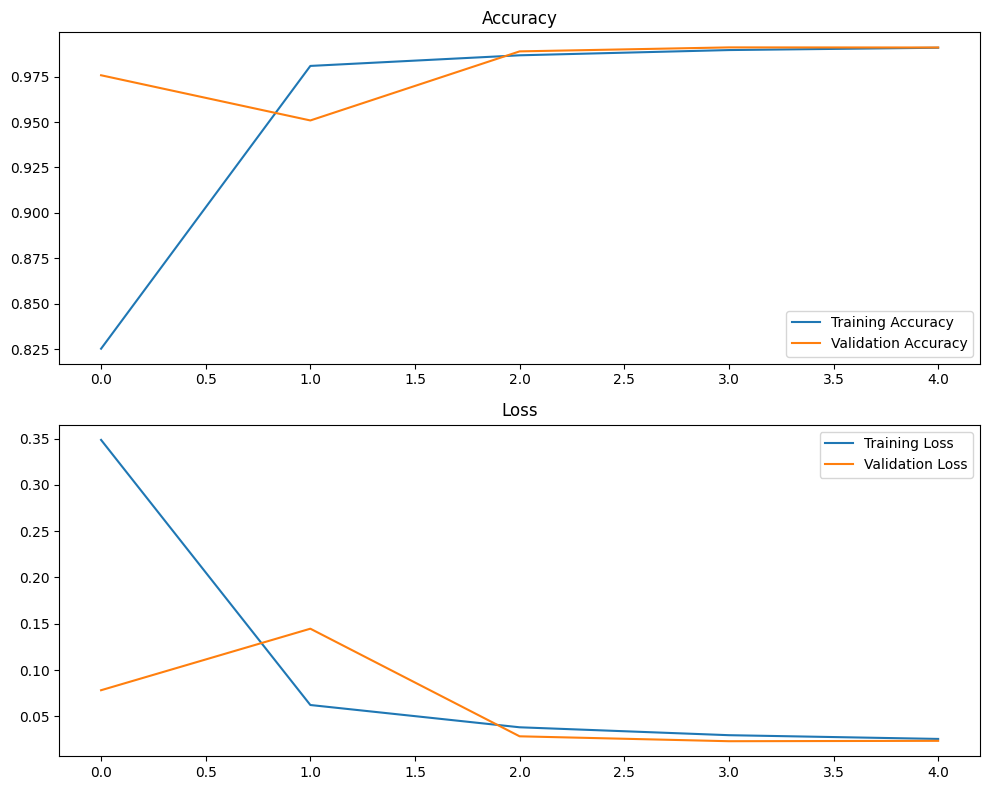

In [38]:
# Plot training and validation accuracy and loss
def plot_history(history):
    fig, axs = plt.subplots(2, 1, figsize=(10, 8))
    # Accuracy plot
    axs[0].plot(history.history['accuracy'], label='Training Accuracy')
    axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axs[0].set_title('Accuracy')
    axs[0].legend()
    # Loss plot
    axs[1].plot(history.history['loss'], label='Training Loss')
    axs[1].plot(history.history['val_loss'], label='Validation Loss')
    axs[1].set_title('Loss')
    axs[1].legend()
    plt.tight_layout()
    plt.show()

plot_history(history)


In [39]:
# Evaluate on validation data
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

# Classification report
y_pred_prob = model.predict(X_val)
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()
print(classification_report(y_val, y_pred))

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
print('Confusion Matrix:')
print(cm)


4210/4210 [==============================] - 13s 3ms/step - loss: 0.0235 - accuracy: 0.9910
Validation Accuracy: 99.10%
4210/4210 [==============================] - 12s 3ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     67346
           1       1.00      0.99      0.99     67346

    accuracy                           0.99    134692
   macro avg       0.99      0.99      0.99    134692
weighted avg       0.99      0.99      0.99    134692

Confusion Matrix:
[[67023   323]
 [  884 66462]]


In [55]:
# Function to process test data
def process_test_data(test_filename, data_dir=TEST_DATA_DIR):
    # Load data
    data, sampling_rate, starttime = load_seismic_data(test_filename, data_dir)
    # Apply bandpass filter
    data = bandpass(data, FREQ_MIN, FREQ_MAX, sampling_rate, corners=4, zerophase=True)
    # Normalize data
    data = (data - np.mean(data)) / np.std(data)
    # Segment data
    segments = []
    segment_times = []
    num_segments = (len(data) - WINDOW_SIZE) // STEP_SIZE + 1
    for i in range(num_segments):
        start_idx = i * STEP_SIZE
        end_idx = start_idx + WINDOW_SIZE
        window_data = data[start_idx:end_idx]
        segments.append(window_data)
        # Calculate the midpoint time of the window
        window_start_time = starttime + timedelta(seconds=start_idx / sampling_rate)
        window_mid_time = window_start_time + timedelta(seconds=(WINDOW_SIZE / (2 * sampling_rate)))
        segment_times.append(window_mid_time)
    # Convert to numpy array and reshape
    segments = np.array(segments)
    segments = segments[..., np.newaxis]
    return data, segments, segment_times, sampling_rate

# List of test files
test_files = [f.replace('.mseed', '') for f in os.listdir(TEST_DATA_DIR) if f.endswith('.mseed')]

detections_list = []

for test_filename in test_files:
    data, segments, segment_times, sampling_rate = process_test_data(test_filename)
    predictions = model.predict(segments)
    predicted_labels = (predictions > 0.8).astype("int32").flatten()
    
    # Find all event indices where prediction is positive
    event_indices = np.where(predicted_labels == 1)[0]
    
    if len(event_indices) == 0:
        # No detections for this file
        continue
    
    max_data_value = np.max(data)
    
    # Initialize variables to track the best detection
    best_detection = None
    smallest_distance = float('inf')
    
    for idx in event_indices:
        event_time = segment_times[idx]
        time_rel_sec = (event_time - segment_times[0]).total_seconds()
        data_index = int(time_rel_sec * sampling_rate)
        
        # Ensure data_index is within bounds
        if data_index >= len(data):
            data_index = len(data) - 1
        elif data_index < 0:
            data_index = 0
        
        data_value = data[data_index]
        distance_to_max = abs(data_value - max_data_value)
        
        # Update best_detection if this event is closer to max_data_value
        if distance_to_max < smallest_distance:
            smallest_distance = distance_to_max
            best_detection = {
                'filename': test_filename,
                'time_abs(%Y-%m-%dT%H:%M:%S.%f)': event_time.strftime('%Y-%m-%dT%H:%M:%S.%f'),
                'time_rel(sec)': time_rel_sec,
                'data_value': data_value,
                'distance_to_max': distance_to_max
            }
    
    # Optionally, you can include additional checks or filters here
    # For example, only add detections where data_value is above a certain threshold
    
    if best_detection is not None:
        # Remove 'data_value' and 'distance_to_max' if not needed
        detection = {
            'filename': best_detection['filename'],
            'time_abs(%Y-%m-%dT%H:%M:%S.%f)': best_detection['time_abs(%Y-%m-%dT%H:%M:%S.%f)'],
            'time_rel(sec)': best_detection['time_rel(sec)']
        }
        detections_list.append(detection)



# Convert the list of detections to a DataFrame
detections = pd.DataFrame(detections_list)


18/18 [==============================] - 0s 2ms/step


In [56]:
# Save the detections to a CSV file
detections.to_csv('S12_GradeA.csv', index=False)
print('Detections saved to seismic_event_detections.csv')


Detections saved to seismic_event_detections.csv


In [ ]:
# # Function to process test data
# def process_test_data(test_filename, data_dir=TEST_DATA_DIR):
#     # Load data
#     data, sampling_rate, starttime = load_seismic_data(test_filename, data_dir)
#     # Apply bandpass filter
#     data = bandpass(data, FREQ_MIN, FREQ_MAX, sampling_rate, corners=4, zerophase=True)
#     # Normalize data
#     data = (data - np.mean(data)) / np.std(data)
#     # Segment data
#     segments = []
#     segment_times = []
#     num_segments = (len(data) - WINDOW_SIZE) // STEP_SIZE + 1
#     for i in range(num_segments):
#         start_idx = i * STEP_SIZE
#         end_idx = start_idx + WINDOW_SIZE
#         window_data = data[start_idx:end_idx]
#         segments.append(window_data)
#         # Calculate the midpoint time of the window
#         window_start_time = starttime + timedelta(seconds=start_idx / sampling_rate)
#         window_mid_time = window_start_time + timedelta(seconds=(WINDOW_SIZE / (2 * sampling_rate)))
#         segment_times.append(window_mid_time)
#     # Convert to numpy array and reshape
#     segments = np.array(segments)
#     segments = segments[..., np.newaxis]
#     return data, segments, segment_times, sampling_rate

# # List of test files
# test_files = [f.replace('.mseed', '') for f in os.listdir(TEST_DATA_DIR) if f.endswith('.mseed')]

# detections_list = []

# for test_filename in test_files:
#     data, segments, segment_times, sampling_rate = process_test_data(test_filename)
#     predictions = model.predict(segments)
#     predicted_labels = (predictions > 0.8).astype("int32").flatten()
#     avg = abs(np.mean(data))
#     event_indices = np.where(predicted_labels == 1)[0]
    
#     previous_event_time = None
#     previous_time_rel_sec = None
#     current_group = {
#         'filename': test_filename,
#         'time_abs_list': [],
#         'time_rel_sec_list': []
#     }
    
#     for idx in event_indices:
#         event_time = segment_times[idx]
#         event_time_str = event_time.strftime('%Y-%m-%dT%H:%M:%S.%f')
#         time_rel_sec = (event_time - segment_times[0]).total_seconds()

#         # Calculate distance metrics
#         data_index = int(time_rel_sec * sampling_rate)
#         if data_index >= len(data):
#             data_index = len(data) - 1  # Prevent out-of-bounds
#         dist_to_max = abs(data[data_index] - np.max(data))
#         dist_to_mean = abs(data[data_index] - np.mean(data))
        
#         if previous_event_time is not None and (time_rel_sec - previous_time_rel_sec) < (0.05 * previous_time_rel_sec):
#             # If the event is close to the previous one, add to the current group
#             current_group['time_abs_list'].append(event_time)
#             current_group['time_rel_sec_list'].append(time_rel_sec)
#         else:
#             # If there's an existing group, finalize and append it to detections_list
#             if current_group['time_abs_list']:
#                 avg_time_rel_sec = np.mean(current_group['time_rel_sec_list'])
#                 avg_event_time = current_group['time_abs_list'][0] + \
#                                  (current_group['time_abs_list'][-1] - current_group['time_abs_list'][0]) / 2
#                 if abs(data[int(avg_time_rel_sec * sampling_rate)] - np.max(data)) > \
#                    abs(data[int(avg_time_rel_sec * sampling_rate)] - np.mean(data)):
#                     detection = {
#                         'filename': test_filename,
#                         'time_abs(%Y-%m-%dT%H:%M:%S.%f)': avg_event_time.strftime('%Y-%m-%dT%H:%M:%S.%f'),
#                         'time_rel(sec)': avg_time_rel_sec
#                     }
#                     detections_list.append(detection)
#                 # Reset current group
#                 current_group = {
#                     'filename': test_filename,
#                     'time_abs_list': [event_time],
#                     'time_rel_sec_list': [time_rel_sec]
#                 }
#             else:
#                 # Start a new group
#                 current_group['time_abs_list'].append(event_time)
#                 current_group['time_rel_sec_list'].append(time_rel_sec)
        
#         previous_event_time = event_time
#         previous_time_rel_sec = time_rel_sec
    
#     # After processing all events, ensure the last group is added
#     if current_group['time_abs_list']:
#         avg_time_rel_sec = np.mean(current_group['time_rel_sec_list'])
#         avg_event_time = current_group['time_abs_list'][0] + \
#                          (current_group['time_abs_list'][-1] - current_group['time_abs_list'][0]) / 2
#         if abs(data[int(avg_time_rel_sec * sampling_rate)] - np.max(data)) > \
#            abs(data[int(avg_time_rel_sec * sampling_rate)] - np.mean(data)):
#             detection = {
#                 'filename': test_filename,
#                 'time_abs(%Y-%m-%dT%H:%M:%S.%f)': avg_event_time.strftime('%Y-%m-%dT%H:%M:%S.%f'),
#                 'time_rel(sec)': avg_time_rel_sec
#             }
#             detections_list.append(detection)



# # Convert the list of detections to a DataFrame
# detections = pd.DataFrame(detections_list)
